5.203967652846744e-13 6.652292639189125e-15
grad_anal (complex)   : (0.0005007312241706588-0.0004121327134337651j)
Re(grad_anal)         : 0.0005007312241706588
Im(grad_anal)         : -0.0004121327134337651
grad_num (finite diff): 0.000500731222978501


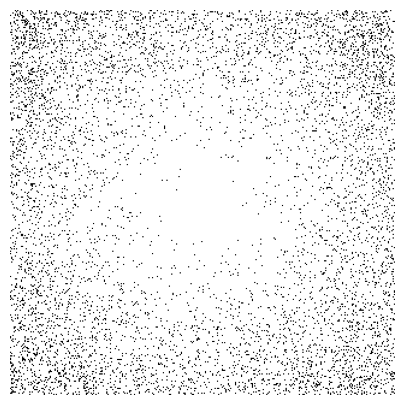

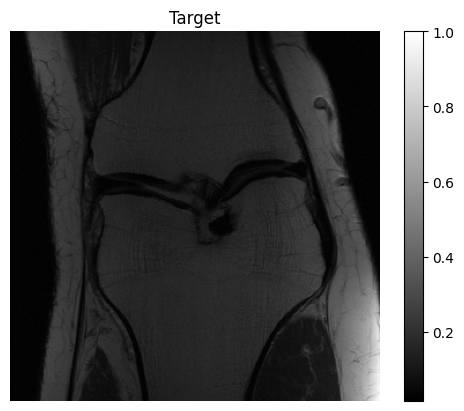

ULA iter    0, grad_norm=1.168e+05, sample_mean=3.125e-03, sample_std=2.053e-03
ULA iter   25, grad_norm=1.326e+05, sample_mean=3.125e-03-6.776e-23j, sample_std=2.067e-03
ULA iter   50, grad_norm=1.461e+05, sample_mean=3.125e-03+2.711e-22j, sample_std=2.080e-03
ULA iter   75, grad_norm=1.578e+05, sample_mean=3.123e-03+2.711e-22j, sample_std=2.092e-03
ULA iter  100, grad_norm=1.685e+05, sample_mean=3.123e-03+0.000e+00j, sample_std=2.104e-03
ULA iter  125, grad_norm=1.782e+05, sample_mean=3.123e-03+0.000e+00j, sample_std=2.115e-03
ULA iter  150, grad_norm=1.866e+05, sample_mean=3.122e-03+0.000e+00j, sample_std=2.124e-03
ULA iter  175, grad_norm=1.945e+05, sample_mean=3.122e-03+1.084e-21j, sample_std=2.136e-03
ULA iter  200, grad_norm=2.015e+05, sample_mean=3.123e-03+0.000e+00j, sample_std=2.145e-03
ULA iter  225, grad_norm=2.079e+05, sample_mean=3.124e-03+0.000e+00j, sample_std=2.154e-03
ULA iter  250, grad_norm=2.143e+05, sample_mean=3.124e-03+0.000e+00j, sample_std=2.164e-03
ULA iter  

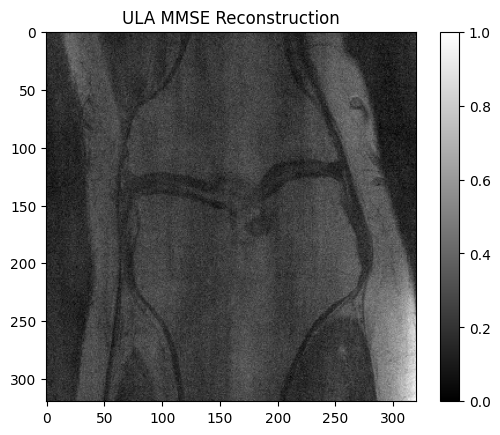

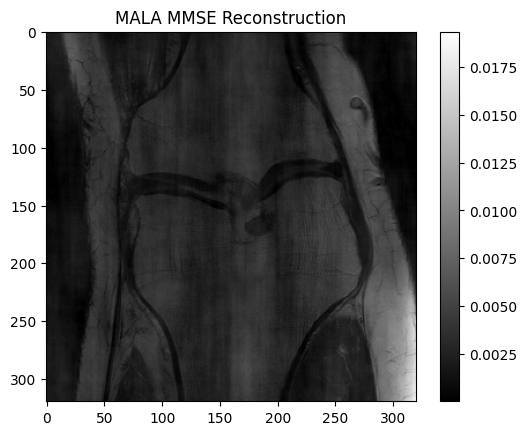

PSNR MALA: -17.19 dB
None


In [1]:
# ULA diagnostics

import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)


mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y = y / np.abs(y).max()

map_estimator = MAPEstimator(mask, 0.95, 0.01, 1e-2) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
ula_estimator = MMSEEstimatorULA(mask, 0.001, 0.1, 1e-2, 1e-9, 350, 2, 150) # stepsize = 1e-2
mala_estimator = MMSEEstimatorMALA(mask, 1, 2, 100e-2, 1e-6, 350, 2, 100)

abs_err, rel_err = map_estimator.adjoint_test(slice_target.shape)
print(abs_err, rel_err)

x0 = np.real(mala_estimator.map_estimator.A_adj(y))
mala_estimator.gradient_check(x0, y)
#map_reconstruct = map_estimator.subgradient_descent(y)


plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# target

plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

# ula mmse
plt.imshow(np.abs(ula_estimator.compute_mmse_estimate(y)), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

plt.imshow(np.abs(mala_estimator.compute_mmse_estimate(y)), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()

# psnr_ula = psnr(ula_estimator.compute_mmse_estimate(y), slice_target)
# print(print(f"PSNR ULA: {psnr_ula:.2f} dB"))

psnr_mala = psnr(mala_estimator.compute_mmse_estimate(y), slice_target)
print(print(f"PSNR MALA: {psnr_mala:.2f} dB"))

# zero_image = np.zeros(slice_target.shape)
# psnr_zero = psnr(zero_image, slice_target)
# print(print(f"PSNR zeros: {psnr_zero:.2f} dB"))